# Microsoft LightGBM
https://github.com/Microsoft/LightGBM

I've seen a few forum questions about Mircosoft's LightGMB recently and I've been trying it out on the Titanic dataset, so figured I'd post a few usage examples for anyone interested. I'd also like to hear ideas and suggestions regarding optimum workflow with LightGBM.

Generally, it feels similar to use to XGBoost (expect a million times easier to compile and install in Python/Windows), but the way it builds trees is somewhat different. I'm not entirely familiar with its intricacies or all the parameters yet, but it seems relatively straight forward to get a reasonable score here with some parameter tuning and only basic features. This will hopefully provide a good starting point for others wishing to try it out.

This notebook includes:  

 - Basic feature engineering (similar to a number of other notebooks, but deliberately kept short)  
 - Data preparation for LightGBM  
      - Creating dataset objects  
      - Setting labels  
      - Setting categorical features  
 - Fitting with early stopping on a validation set using different metrics  
      - Example parameters to play with  
      - Scores ~0.785  
 - Model assessment   
      - General AUC, accuracy.  
      - Plotting and using feature importance  
 - Predicting  
      - Weirdly (?) not using a dataset object  
 - Using LightGBM in a skLearn pipeline for parameter tuning  
      - Scores ~0.795  
 - Running k-fold cross validation  
      - Just an example, not used to create a submission here  

This notebook lacks:  

  - More sophisticated feature engineering  
  - Well tuned hyperparameters  
  - Benchmarking of speed and performance vs XGBoost   
  
I'd be interested to see how well people can get LightGBM performing with some good features and some more guided parameter tuning!

In [1]:
#%% Imports

# The usuals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Regular expressions (urrggghhhhhhhhh) for handling string features
import re

# LightGBM
import lightgbm as lgb

# sklearn tools for model training and assesment
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, auc, accuracy_score)
from sklearn.model_selection import GridSearchCV


## Feature engineering  
This section of the notebook deals with cleaning the data and creation of new features. I've deliberately kept it as short as possible as it's not really my focus here, but I'd certainly encourage anyone looking to improve this script to start here. The following steps are performed:

 - Data is imported  
 - Some cabin-related features are created  
 - Feature relating to family are added  
 - Title column is cleaned and handled as per other notebooks  
 - Categorical columns are converted to pd.Categorical's and then replaced with their cat codes. This is lazy, and drops information that would be useful in assessing feature importance later.  
 - Missing Age values are replaced with the median of the whole dataset - see other notebooks for better ways of dealing with these values.  


In [2]:
#%% Import data

# Import both data sets
trainRaw = pd.read_csv('../input/train.csv')
testRaw = pd.read_csv('../input/test.csv')

# And concatonate together
nTrain = trainRaw.shape[0]
full = pd.concat([trainRaw, testRaw], axis=0)


#%% Cabins

def ADSplit(s):
    """
    Function to try and extract cabin letter and number from the cabin column.
    Runs a regular expression that finds letters and numbers in the 
    string. These are held in match.group, if they exist.
    """

    match = re.match(r"([a-z]+)([0-9]+)", s, re.I)
    
    try:
        letter = match.group(1)
    except:
        letter = ''
    
    try:
        number = match.group(2)
    except:
        number = 9999

    return letter, number


def DR(s):
    """
    From the cabin string, try and extract letter, number, and number of cabins
    """
    
    # Check contents
    if isinstance(s, (int, float)):
        # If field is empty, return nothing
        letter = ''
        number = ''
        nRooms = 9999
    else:
        # If field isn't empty, split sting on space. Some strings contain 
        # multiple cabins.
        s = s.split(' ')
        # Count the cabins based on number of splits
        nRooms = len(s)
        # Just take first cabin for letter/number extraction
        s = s[0]
        
        letter, number = ADSplit(s)
   
    return [letter, number, nRooms]

# Apply DR function to each cell in Cabin column using pandas apply method.    
out = full['Cabin'].apply(DR)
# Outout tuple with 3 values for each row, convert this to pandas df
out = out.apply(pd.Series)
# And name the columns
out.columns = ['CL', 'CN', 'nC']
    
# Then concatenate these columns to the dataset
full = pd.concat([full, out], axis=1)
    

#%% Family 

# Add some family features directly to new columns in the dataset
# Size
full['fSize'] = full['SibSp'] + full['Parch'] + 1
# Ratio
full['fRatio'] = (full['Parch']+1) / (full['SibSp']+ 1)
# Adult?
full['Adult'] = full['Age']>18    


#%% Names
# Extract titles from Name column, standardise

titleDict = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Sir",
    "Don": "Sir",
    "Sir": "Sir",
    "Dr": "Dr",
    "Rev": "Rev",
    "theCountess": "Lady",
    "Dona": "Lady",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master",
    "Lady": "Lady"
}


def splitName(s, titleDict):
    """
    Extract title from name, replace with value in title dictionary. Also 
    return surname.
    """
    
    # Remove '.' from name string
    s = s.replace('.', '')
    # Split on spaces
    s = s.split(' ')
    # get surname
    surname = s[0]

    # Get title - loop over titleDict, if s matches a key, take the 
    # corresponding value as the title
    title = [t for k,t in titleDict.items() if str(k) in s]
   
    # If no matching keys in title dict, use 'Other'.
    if title == []:
        title = 'Other'
    else:
        # Title is a list, so extract contents
        title = title[0]
    
    # Return surname (stripping remaining ',') and title as string
    return surname.strip(','), title


# Apply functions to df and concatenate new columns as before
out = full['Name'].apply(splitName, args=[titleDict])
out = out.apply(pd.Series)
out.columns = ['Surname', 'Title']
  
full = pd.concat([full, out], axis=1)


#%% Categorical columns

# List of categorical columns to recode
catCols = ['Sex', 'Embarked', 'CL', 'CN', 'Surname', 'Title']

# Recode
for c in catCols:
    # Convert column to pd.Categotical
    full[c] = pd.Categorical(full[c])
    # Extract the cat.codes and replace the column with these
    full[c] = full[c].cat.codes
    # Convert the cat codes to categotical...    
    full[c] = pd.Categorical(full[c])


# Generate a logical index of categorical columns to maybe use with LightGBM later
catCols = [i for i,v in enumerate(full.dtypes) if str(v)=='category']


#%% Age

# Replace missing age values with median. 
# See ither kernels for more sophisticated ways of doing this!
full.loc[full.Age.isnull(), 'Age'] = np.median(full['Age'].loc[full.Age.notnull()])


#%% Split datasets

train = full.iloc[0:nTrain,:]
test = full.iloc[nTrain::,:]

## Model fitting

LightGBM handles data in a similar fashion to XGBoost in that it uses its own dataset objects. These are created with **lgb.Dataset** and hold the data, labels, lists of categorical features, etc.

For some reason, for prediction LightGBM expects raw data as input rather than its own dataset object, so the following function prepares the data:  

  - The class column, if specified, is split off in to a separate vector (labels)  
  - The ID column, if specified, is split off in to a separate vector (IDs)  
  - Columns specified in fDrop are removed  
  - The data set object is created from the remaining columns and with the labels specified separately. Categorical features are set to auto, so this set according to the datatype of each pandas dataframe column.
  - The corresponding raw data set is also returned for use with the prediction functions   


In [3]:
def prepLGB(data, classCol = '', IDCol = '', fDrop = []):
    
        # Drop class column
        if classCol != '':
            labels = data[classCol]
            fDrop = fDrop + [classCol]
        else:
            labels = []
    
        if IDCol != '':
            IDs = data[IDCol]
        else:
            IDs = []

        if fDrop != []:
           data =  data.drop(fDrop, axis=1)
       
        # Create LGB mats        
        lData = lgb.Dataset(data, label=labels, free_raw_data=False, 
                            feature_name=list(data.columns),
                            categorical_feature = 'auto')
        
        return lData, labels, IDs, data

### Fitting with early stopping

Initially scored ~0.785, but I've faffed around a lot with the parameters since then. 

Training is done using **lgb.train** and takes a **lgb.Dataset**. The metric specified in params is applied to the valid_sets on each step, and early stopping is based on the last set specified.

Prediction is done for each set using the raw data, and the best iteration from early stopping is used.

In [4]:
# Specify columns to drop
fDrop = ['Ticket', 'Cabin', 'Name']

# Split training data in to training and validation sets. 
# Validation set is used for early stopping.
trainData, validData = train_test_split(train, test_size=0.4)

# Prepare the data sets
trainDataL, trainLabels, trainIDs, trainData = prepLGB(trainData, 
                                                 classCol = 'Survived', 
                                                 IDCol = 'PassengerId',
                                                 fDrop = fDrop)
                                                 
validDataL, validLabels, validIDs, validData = prepLGB(validData, 
                                                 classCol = 'Survived', 
                                                 IDCol = 'PassengerId',
                                                 fDrop = fDrop)

testDataL, _, _ , testData = prepLGB(test, 
                                 classCol = 'Survived', 
                                 IDCol = 'PassengerId',
                                 fDrop = fDrop)

# Set params
# Scores ~0.784    
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary', 
          'nthread': 5, 
          'silent': True,
          'num_leaves': 64, 
          'learning_rate': 0.05, 
          'max_bin': 512, 
          'subsample_for_bin': 200,
          'subsample': 1, 
          'subsample_freq': 1, 
          'colsample_bytree': 0.8, 
          'reg_alpha': 5, 
          'reg_lambda': 10,
          'min_split_gain': 0.5, 
          'min_child_weight': 1, 
          'min_child_samples': 5, 
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

# Train model
gbm = lgb.train(params, 
                trainDataL, 
                100000, # Max number of trees
                valid_sets=[trainDataL, validDataL],
                early_stopping_rounds = 50,
                verbose_eval = 4)


# Run prediction on training, validation, and test sets using raw data
# Specify which model iteration to use
predsValid = gbm.predict(validData, num_iteration=gbm.best_iteration)
predsTrain = gbm.predict(trainData, num_iteration=gbm.best_iteration)
predsTest = gbm.predict(testData, num_iteration=gbm.best_iteration)

Train until valid scores didn't improve in 50 rounds.
[4]	training's binary_error: 0.194757	valid_1's binary_error: 0.212885
[8]	training's binary_error: 0.185393	valid_1's binary_error: 0.207283
[12]	training's binary_error: 0.185393	valid_1's binary_error: 0.207283
[16]	training's binary_error: 0.185393	valid_1's binary_error: 0.207283
[20]	training's binary_error: 0.181648	valid_1's binary_error: 0.207283
[24]	training's binary_error: 0.177903	valid_1's binary_error: 0.19888
[28]	training's binary_error: 0.174157	valid_1's binary_error: 0.179272
[32]	training's binary_error: 0.179775	valid_1's binary_error: 0.170868
[36]	training's binary_error: 0.168539	valid_1's binary_error: 0.173669

[40]	training's binary_error: 0.181648	valid_1's binary_error: 0.168067
[44]	training's binary_error: 0.181648	valid_1's binary_error: 0.168067
[48]	training's binary_error: 0.181648	valid_1's binary_error: 0.168067
[52]	training's binary_error: 0.164794	valid_1's binary_error: 0.173669
[56]	trainin

### Model assessment

Assess accuracy and AUC for the model. Also, plot feature importance ranked by "split" and "gain". See ?**lgb.plot_importance** for more info.

/opt/conda/bin/ipython:14: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


Train accuracy: 0.818352059925 | Train AUC: 0.874378742515
Validation accuracy: 0.831932773109 | Test AUC: 0.868080576482
------------------------------


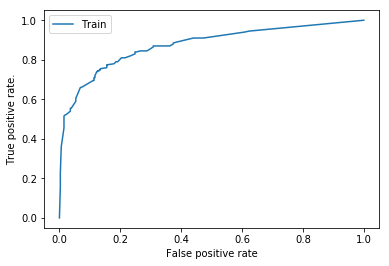

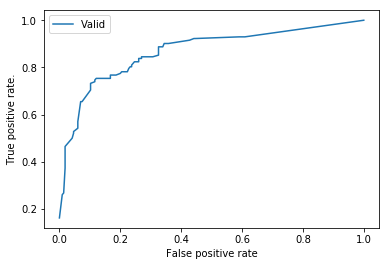

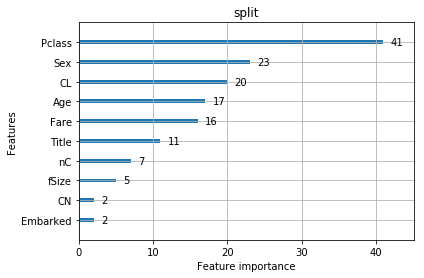

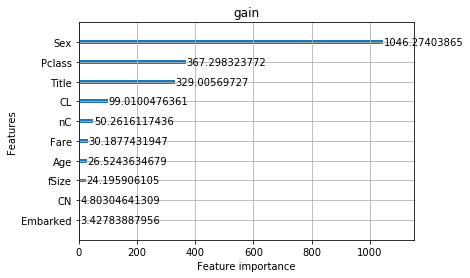

[17  2 16  0  0 41 23  0 20  2  7  5  0  0  0 11]
[   26.52436347     3.42783888    30.18774319     0.             0.
   367.29832377  1046.27403865     0.            99.01004764     4.80304641
    50.26161174    24.1959061      0.             0.             0.
   329.00569727]


In [5]:
  def assessMod(predsTrain, yTrain, predsValid=[], yValid=[], 
              report=True, plot=True):
    """
    Using sklearn functions, return accuracy and ROC metrics (tpr, fpr, auc)
    for training data and validation data (if included).
    
    preds should be model preditions, yTrain and yValid should be labels.
    
    """
    trainAcc = accuracy_score(yTrain, np.round(predsTrain))
    fprTrain, tprTrain, thresholdsTrain = roc_curve(yTrain, predsTrain)
    trainAUC =  auc(fprTrain, tprTrain)
    
    if predsValid != []:
        accuracy_score(yValid, np.round(predsValid))
        fprValid, tprValid, thresholdsValid = roc_curve(yValid, predsValid)
        validAcc = accuracy_score(yValid, np.round(predsValid))
        validAUC = auc(fprValid, tprValid)
    else: 
        validAcc = np.nan
        fprValid = np.nan
        tprValid = np.nan
        validAUC = np.nan
   
    if report:
        print('Train accuracy:', trainAcc, '| Train AUC:', 
             trainAUC)
        if not isinstance(predsValid, list):
            print('Validation accuracy:', validAcc, '| Test AUC:', 
                  validAUC)
        
        print('-'*30)
    
    # Plot
    if plot:
        plotROC(tprTrain, fprTrain, label='Train')
        if not isinstance(predsValid, list):
            plotROC(tprValid, fprValid, label='Valid')
      
    # Stats output
    stats = {'fprTrain' : fprTrain,
             'fprValid' : fprValid,
             'tprTrain' : tprTrain,
             'tprValid' : tprValid,
             'trainAcc' : trainAcc,
             'validAcc' : validAcc,
             'trainAUC' : trainAUC,
             'validAUC' : validAUC}

    return stats
  
    
def plotROC(tpr, fpr, label=''):
    """
    Plot ROC curve from tpr and fpr.
    """
    plt.plot(fpr, tpr, label=label)
    plt.legend()
    plt.ylabel('True positive rate.')
    plt.xlabel('False positive rate')
    plt.show()


# Report model performance on training and validation sets                       
assessMod(predsTrain, trainLabels, 
          predsValid = predsValid, yValid = validLabels, 
          report=True, plot=True)             

# Plot importance
lgb.plot_importance(gbm, importance_type="split", title="split")
plt.show()

lgb.plot_importance(gbm, importance_type="gain", title='gain')
plt.show()

# Importance values are also available in:
print(gbm.feature_importance("split"))
print(gbm.feature_importance("gain"))

In [6]:
# Save submission
sub = pd.DataFrame()
sub['PassengerId'] = test['PassengerId']
sub['Survived'] = np.int32(predsTest>0.5)
sub.to_csv('sub1.csv', index=False)

## Parameter tuning

LightGBM is compatible with scikit's grid search. This approach sets a parameter grid to search (this is a small problem, so go crazy), creates the grid using **lgb.LGBMClassifier**, and extracts the best parameters based on 5-fold CV.

This grid of parameters should score ~0.795.

In [8]:
# Prepare data set using all the training data
allTrainDataL, allTrainLabels, _ , allTrainData = prepLGB(train, 
                                                 classCol = 'Survived', 
                                                 IDCol = 'PassengerId',
                                                 fDrop = fDrop)
# Create parameters to search
gridParams = {
    'learning_rate': [0.01],
    'n_estimators': [24,48],
    'num_leaves': [6,12,20,30],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'seed' : [500],
    'colsample_bytree' : [0.7,0.8],
    'subsample' : [0.7,1],
    'reg_alpha' : [1],
    'reg_lambda' : [0,1],
    }

# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective='binary', 
          nthread= 5, 
          silent= True,
          max_depth= -1,
          max_bin= 128, 
          subsample_for_bin= 500,
          subsample= 1, 
          subsample_freq= 1, 
          min_split_gain = 0.5, 
          min_child_weight = 1, 
          min_child_samples = 5, 
          scale_pos_weight = 1)

# To view the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=1, cv=5, n_jobs=-1)
# Run the grid
grid.fit(allTrainData, allTrainLabels)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.5min finished


{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.01, 'n_estimators': 48, 'num_leaves': 6, 'objective': 'binary', 'reg_alpha': 1, 'reg_lambda': 0, 'seed': 500, 'subsample': 0.7}
0.824915824916


### Retrain, predict

Using the parameters from above, train a new model. Here I'm doing this using early stopping again, but as we have an idea of the optimum number of trees to use, it might be worth sepcifying these and training on the entire training set without early stopping.


Train until valid scores didn't improve in 50 rounds.
[4]	training's binary_error: 0.181648	valid_1's binary_error: 0.190476
[8]	training's binary_error: 0.177903	valid_1's binary_error: 0.182073
[12]	training's binary_error: 0.177903	valid_1's binary_error: 0.193277
[16]	training's binary_error: 0.162921	valid_1's binary_error: 0.204482
[20]	training's binary_error: 0.157303	valid_1's binary_error: 0.196078
[24]	training's binary_error: 0.161049	valid_1's binary_error: 0.196078
[28]	training's binary_error: 0.155431	valid_1's binary_error: 0.190476
[32]	training's binary_error: 0.149813	valid_1's binary_error: 0.184874
[36]	training's binary_error: 0.155431	valid_1's binary_error: 0.187675
[40]	training's binary_error: 0.151685	valid_1's binary_error: 0.179272
[44]	training's binary_error: 0.161049	valid_1's binary_error: 0.184874
[48]	training's binary_error: 0.159176	valid_1's binary_error: 0.184874
[52]	training's binary_error: 0.159176	valid_1's binary_error: 0.184874
[56]	trainin

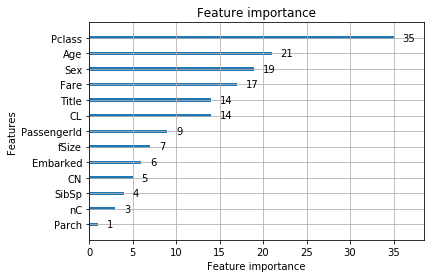

/opt/conda/bin/ipython:14: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


Train accuracy: 0.850187265918 | Train AUC: 0.885479041916
Validation accuracy: 0.809523809524 | Test AUC: 0.877464788732
------------------------------


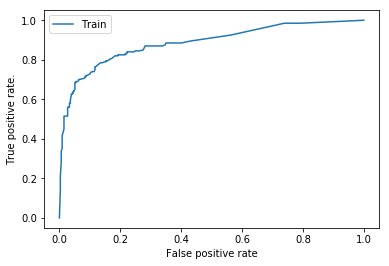

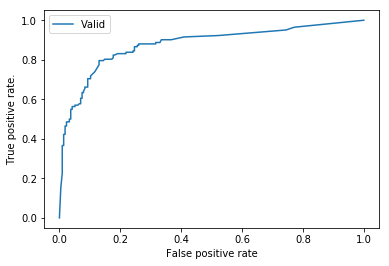

In [9]:
# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate'] 
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']
 
# Train     
gbm = lgb.train(params, 
                trainDataL, 
                100000, 
                valid_sets=[trainDataL, validDataL],
                early_stopping_rounds = 50,
                verbose_eval=4)


# Plot importance
lgb.plot_importance(gbm)
plt.show()

# Predict
predsValid = gbm.predict(validData, num_iteration=gbm.best_iteration)
predsTrain = gbm.predict(trainData, num_iteration=gbm.best_iteration)
predsTest = gbm.predict(testData, num_iteration=gbm.best_iteration)

# Print assessment
assessMod(predsTrain, trainLabels, predsValid=predsValid, yValid= validLabels, 
          report=True, plot=True)               

# Save submission
sub = pd.DataFrame()
sub['PassengerId'] = test['PassengerId']
sub['Survived'] = np.int32(predsTest>0.5)
sub.to_csv('sub2.csv', index=False)                       

## K-fold crossvalidation

Run k-fold crossvalidation on a set of parameters using lgb.cv. This ouputs a cv_result object, which contains the mean and std of each fold's model.



In [ ]:

# Using a set of parameters (just using those from above)   
params = {'metric' : 'binary_error'}

# Run k-fold crossvalidation on all the training data 
cv_results = lgb.cv(params, 
                     allTrainDataL, # Using all training data
                     num_boost_round = 10000, 
                     nfold = 20, 
                     stratified = False, 
                     shuffle = True, 
                     early_stopping_rounds = 20, 
                     verbose_eval = 10, 
                     show_stdv = True, 
                     seed = 0)

# Example plot
plt.errorbar(x=range(0, len(cv_results['binary_error-mean'])),
             y=cv_results['binary_error-mean'], 
             yerr=cv_results['binary_error-stdv'])
plt.xlabel('Num trees')
plt.ylabel('Binary_error')
plt.show()